# Compare the strategies generated

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as xp
from datetime import date

from trading import Asset
from trading.processes import Simulation

In [2]:
pwd = "results/{}.csv"
all_Df = pd.DataFrame()

In [3]:
def separate(df):
    df[ [ "route_aux", "strategy", "strategy_params", "risk", "risk_opt", "opt_params" ] ] = df["route"].str.split( "/", expand=True )
    df.drop(columns = ["route_aux"], inplace = True)
    return df

In [4]:
def plots(df, best = 2):

    plt.figure(figsize = (6,4))
    
    for i in range( best ):
        dfa = pd.read_csv( df["route"].iloc[i] + "/resume.csv" )
        dfa.set_index("start", inplace = True)
        dfa.index = pd.to_datetime( dfa.index )
        dfa["acc"].plot(label = f"{i} Best")
        # pd.read_csv( df["route"].iloc[1] + "/resume.csv" )["acc"].plot(label = "Second best")

    plt.title("Best strategy based on acc")
    plt.legend()
    plt.xlabel("Months")
    plt.ylabel("Performance")
    plt.show()

    xp.box( df, x = "strategy", y = "acc", title = "Strategies with params" ).show()
    xp.box( df, x = "risk", y = "acc", color = "opt_params", title = "Portfolio optimization" ).show()
    xp.box( df, x = "strategy_params", y = "acc", title = "Freq params" ).show()

    

In [69]:
def build_strategy(strategy, run = True, broker = "gbm", fiat = "MX", **kwargs):
    sim = Simulation(
        broker=broker,
        fiat = fiat,
        end = kwargs.get( "end", date(2022, 1 ,1)),
        simulations= kwargs.get("simulations", 36),
        commission=0,
        verbose = 0
    )

    sim.analyze(
        frequency=kwargs.get("frequency", "1m"),
        test_time=1,
        analysis=strategy,
        run = run
    )

    sim.optimize(
        balance_time = 36,
        # frequency="1m",
        risk = "efficientsemivariance",
        objective = "minsemivariance",
        run = run
    )

    df = sim.results_compilation()
    print( df.iloc[ 0 ] )

    df = sim.behaviour( df["route"].iloc[0] )

    return df

In [247]:
from trading.func_brokers import get_assets
from trading import Asset
from trading.optimization.pyportfolio import PyPort

import matplotlib.pyplot as plt
import pandas as pd
from dateutil.relativedelta import relativedelta

class SimulationV2():
    def __init__(self, broker, fiat, start, end, frequency, **kwargs ):
        self.broker = broker
        self.fiat = fiat
        self.start = start
        self.end = end
        self.frequency = frequency

        self.source = "db"

        for i,v in kwargs.items(): setattr( self, i, v )

        self.assets = get_assets()[ self.broker ]

        self.df = self.get_df()

    def get_df(self):
        df = pd.DataFrame()
        symbols_list = []
        self.assets_df = {}
        for symbol in self.assets:
            asset = Asset(
                symbol=symbol,
                broker = self.broker,
                fiat = self.fiat,
                start = self.start,
                end = self.end,
                frequency = self.frequency,
                source = self.source
            )

            if asset is None or asset.df is None or len(asset.df) == 0:
                continue

            asset.df.index = pd.to_datetime( asset.df.index )

            if self.frequency == "1m":
                asset.df = asset.df[ asset.df.index.map(lambda x : x.day == 1) ]
            
            asset.df.sort_index(ascending = True, inplace = True)

            df = pd.concat([ df, asset.df[["close"]] ], axis = 1)
            symbols_list.append(symbol)
            self.assets_df[ symbol ] = asset

        df.columns = symbols_list

        return df

    def analysis(self, func, simulations = None):

        self.analysis_df = pd.concat([ func(asset) for _, asset in self.assets_df.items() ], axis = 1)
        self.analysis_df.columns = [ symbol for symbol,_ in self.assets_df.items() ]

        self.simulations = simulations
        self.sim_start = self.start
        if simulations is not None:
            d = { 
                {
                    "1m":"months",
                    "1w":"weeks",
                    "1d":"days",
                    "1min":"minutes"
                }[self.frequency]:self.simulations 
            }
            self.sim_start = self.start if self.simulations is None else self.end - relativedelta( **d )

            self.analysis_df = self.analysis_df.iloc[ -simulations: ]
    
    def filter(self, filter, series, filter_qty = None):
        if filter == "positive": 
            series = series[ series > 0 ]
        
        else:
            filter_qty = filter_qty if filter_qty >= 1 else int( filter_qty * len(series) )
            if filter_qty == "highest":
                series = series.sort_values(ascending = False)[ : filter_qty]
            elif filter_qty == "lowest":
                series = series.sort_values(ascending = True)[ : filter_qty]
        
        return series

    def optimize(self, risk, objective = "", period = 10,  exp_returns = "mean", target_return = 0.01, verbose = 0, filter = None, filter_qty = None):
        
        allocation_dict, qty_dict, pct_dict = {}, {}, {}

        for date_ in self.analysis_df.index:

            if filter is not None:
                series = self.filter( filter,  self.analysis_df.loc[ date_ ], filter_qty)
                if len(series) == 0:
                    continue
                price_df = self.df[ series.index ]
                print(len(price_df.columns))

            else:
                series = self.analysis_df.loc[ date_ ]
                price_df = self.df

            if risk == "1/N":
                l = len(series)
                allocation = qty = pct = { symbol:(1/l) for symbol in price_df.columns }
            else:

                opt = PyPort(
                    value = 0,
                    df = price_df.loc[ :date_ ],
                    exp_returns= series if exp_returns else price_df.loc[ :date_ ],
                    risk = risk,
                    objective = objective,
                    time = period,
                    limits = (0,1),
                    target_return=target_return,
                    verbose = verbose,
                )

                allocation = None

                try:
                    allocation, qty, pct = opt.optimize(  )
                except Exception as e:
                    print("Couldnt generate portfolio. \nException: {}".format(e))
                    continue

            allocation_dict[ date_ ] = allocation
            qty_dict[ date_ ] = qty
            pct_dict[ date_ ] = pct
        
        print(allocation_dict)
        self.allocation = pd.DataFrame.from_dict(allocation_dict).T# .dropna(axis = 0)
        self.qty = pd.DataFrame.from_dict(qty_dict).T# .dropna(axis = 0)
        self.pct = pd.DataFrame.from_dict(pct_dict).T# .dropna(axis = 0)

    def validate(self):
        self.behavior = pd.DataFrame() 
        self.behavior["returns"] = (self.df.pct_change().shift(-1) * self.pct).sum(axis = 1)

        self.behavior = self.behavior.loc[ self.sim_start: ]

        self.behavior["acc"] = (self.behavior["returns"] + 1).cumprod()

        self.resume = {
            "mean":self.behavior["returns"].mean(),
            "std":self.behavior["returns"].std(),
            "max drawdown":self.behavior["returns"].min(),
            "sharpe":self.behavior["returns"].mean() / self.behavior["returns"].std(),
            # "sortino":(self.behavior[ self.behavior["returns"] > 0].mean() / self.behavior["returns"].std()  ),
            "acc":self.behavior["acc"].iloc[-1]
        }

        return self.resume

    def plot(self, column = "acc", **kwargs):
        self.behavior[ column ].plot(figsize = (10,4))
        plt.title( f"Simulation of {self.broker} from { self.sim_start } to {self.end} in {self.frequency} frequency." )
        plt.xlabel("Date")
        plt.ylabel("Returns")



In [248]:
def build_strategy_v2(strategy, broker = "gbm", fiat = "MX", **kwargs):
    sim = SimulationV2( 
        broker= broker, 
        fiat = fiat, 
        start = date(1990,1,1), 
        end = date(2021,12,1), 
        frequency="1m"
    )

    sim.analysis( func = strategy , simulations = 36)

    sim.optimize( risk = "efficientsemivariance", objective = "minsemivariance", period = 30 , 
        
            filter = kwargs.get("filter", "positive"),
            filter_qty= kwargs.get("filter_qty", None)
        )

    print(sim.validate())

    return sim.behavior, sim

## Benchmarks

### Min Volatility

In [6]:
bench = pd.read_csv( pwd.format("minvol") )

In [7]:
bench

,route,sharpe,sortino,std,neg std,min net,acc,mean net
0,C:\Users\ramon\Documents\Trading\WorkingDir\gb...,0.416614,0.823212,0.029178,0.014767,-0.039612,1.522964,0.012156
1,C:\Users\ramon\Documents\Trading\WorkingDir\gb...,0.466525,1.150812,0.024017,0.009736,-0.029360,1.478935,0.011205
2,C:\Users\ramon\Documents\Trading\WorkingDir\gb...,0.448169,1.415026,0.022945,0.007267,-0.022356,1.432461,0.010283
3,C:\Users\ramon\Documents\Trading\WorkingDir\gb...,0.461750,1.305526,0.021974,0.007772,-0.026955,1.426514,0.010147
4,C:\Users\ramon\Documents\Trading\WorkingDir\gb...,0.343049,0.938687,0.019340,0.007068,-0.026686,1.260661,0.006635
5,C:\Users\ramon\Documents\Trading\WorkingDir\gb...,0.282932,0.685523,0.018851,0.007780,-0.030281,1.203725,0.005334
6,C:\Users\ramon\Documents\Trading\WorkingDir\gb...,0.138402,0.175689,0.028493,0.022446,-0.071856,1.096608,0.003944
7,C:\Users\ramon\Documents\Trading\WorkingDir\gb...,1.212350,NaN,0.010155,NaN,0.005131,1.024723,0.012311
8,C:\Users\ramon\Documents\Trading\WorkingDir\gb...,0.055708,0.088403,0.021606,0.013615,-0.051210,1.023787,0.001204
9,C:\Users\ramon\Documents\Trading\WorkingDir\gb...,0.110535,0.201507,0.014093,0.007731,-0.025266,1.020716,0.001558


In [8]:
for i in range( len(bench) ):
    print( bench["route"].iloc[i] )

C:\Users\ramon\Documents\Trading\WorkingDir\gbm\results\MX\1m_1/MinVols/10_/efficientsemivariance/minsemivariance/1_1m_10
C:\Users\ramon\Documents\Trading\WorkingDir\gbm\results\MX\1m_1/MinVols/10_/efficientsemivariance/minsemivariance/1_1m_20
C:\Users\ramon\Documents\Trading\WorkingDir\gbm\results\MX\1m_1/MinVols/10_/efficientsemivariance/minsemivariance/1_1m_50
C:\Users\ramon\Documents\Trading\WorkingDir\gbm\results\MX\1m_1/MinVols/10_/efficientsemivariance/minsemivariance/1_1m_70
C:\Users\ramon\Documents\Trading\WorkingDir\gbm\results\MX\1m_1/MinVols/10_/efficientsemivariance/minsemivariance/1_1m_30
C:\Users\ramon\Documents\Trading\WorkingDir\gbm\results\MX\1m_1/MinVols/10_/efficientsemivariance/minsemivariance/1_1m_100
C:\Users\ramon\Documents\Trading\WorkingDir\gbm\results\MX\1m_1/MinVols/10_/efficientfrontier/minvol/1_1m_10
C:\Users\ramon\Documents\Trading\WorkingDir\gbm\results\MX\1m_1/MinVols/10_/efficientfrontier/minvol/1_1m_50
C:\Users\ramon\Documents\Trading\WorkingDir\gbm\r

In [9]:
bench_df = pd.read_csv( bench["route"].iloc[0] + "/resume.csv" )
all_Df = bench_df[["acc", "start"]]
all_Df.rename(columns = { "acc":"minsemivariance", "start":"date" }, inplace = True)
all_Df.set_index("date", inplace = True)

<AxesSubplot:xlabel='date'>

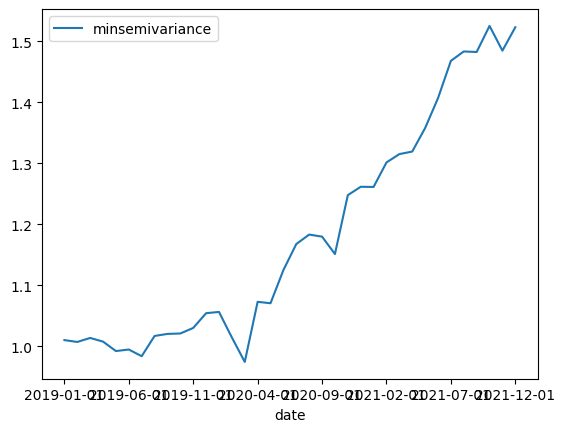

In [10]:
all_Df.plot()

### Indexes and CETES

In [11]:
import yfinance as yf

In [12]:
df = yf.download("^MXX", start = date(2018,12,1), end = date.today(), interval= "1mo" ,progress=False)
all_Df["mexbol"] = (df["Close"].pct_change() + 1).cumprod()

df = yf.download("^GSPC", start = date(2018,12,1), end = date.today(), interval= "1mo" ,progress=False)
all_Df["s&p"] = (df["Close"].pct_change() + 1).cumprod()

### All Benchmarks

<AxesSubplot:xlabel='date'>

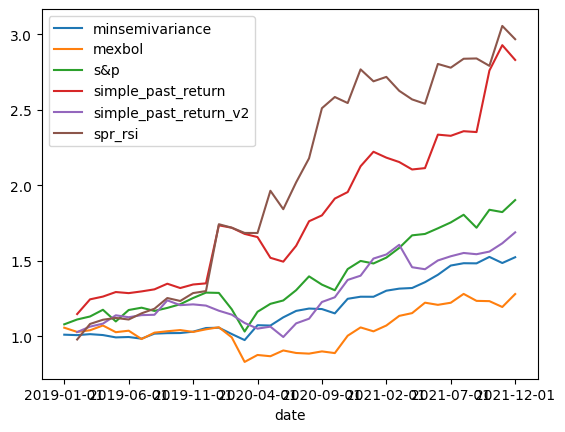

In [177]:
all_Df.plot()

## Previous pass returns

#### Results
Simple and good strategy.

Can overtake the benchmarks.

~2.7 mul with and around of **39% anually.**

In [82]:
def simple_past_returns(asset):
    
    return asset.df["close"].pct_change().iloc[-1]

In [42]:
spr_strategy = {
    "SimplePastReturns":{
        "function":simple_past_returns,
        "time":10,
        "type":"filter",
        "filter":"highest",
        "filter_qty": 0.3
    }
}

In [47]:
simple_past_returns_df = build_strategy( spr_strategy, run = False )

Folder already exists C:\Users\ramon\Documents\Trading\WorkingDir\binance\results\USDT\1d_1/SimplePastReturns/10_
AMBUSDT csv does not exist in daily interval in path C:\Users\ramon\Documents\Trading\WorkingDir\binance\data\daily\AMBUSDT.csv.
OAXUSDT csv does not exist in daily interval in path C:\Users\ramon\Documents\Trading\WorkingDir\binance\data\daily\OAXUSDT.csv.
QLCUSDT csv does not exist in daily interval in path C:\Users\ramon\Documents\Trading\WorkingDir\binance\data\daily\QLCUSDT.csv.
SKYUSDT csv does not exist in daily interval in path C:\Users\ramon\Documents\Trading\WorkingDir\binance\data\daily\SKYUSDT.csv.
AMBUSDT csv does not exist in daily interval in path C:\Users\ramon\Documents\Trading\WorkingDir\binance\data\daily\AMBUSDT.csv.
OAXUSDT csv does not exist in daily interval in path C:\Users\ramon\Documents\Trading\WorkingDir\binance\data\daily\OAXUSDT.csv.
QLCUSDT csv does not exist in daily interval in path C:\Users\ramon\Documents\Trading\WorkingDir\binance\data\da

In [23]:
all_Df["simple_past_return"] = simple_past_returns_df["acc"]

<AxesSubplot:xlabel='date'>

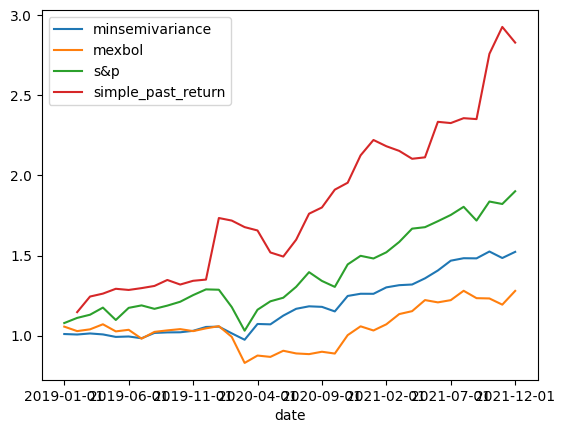

In [25]:
all_Df.plot()

## Previous past returns v2

Not only consider past returns but the two past returns

#### Results
It has proven very bad returns.
Below S&P but above minsemivariance.

In [50]:
def simple_past_returns_v2(asset):
    
    return asset.df["close"].pct_change( periods = 2 ).iloc[-1]

sprv2_strategy = {
    "SimplePastReturns_v2":{
        "function":simple_past_returns_v2,
        "time":10,
        "type":"filter",
        "filter":"highest",
        "filter_qty": 0.3
    }
}

In [35]:
simple_past_returns_v2_df = build_strategy( sprv2_strategy, run = True )

Folder already exists C:\Users\ramon\Documents\Trading\WorkingDir\gbm\results\MX\1m_1/SimplePastReturns_v2/10_
Folder already exists C:\Users\ramon\Documents\Trading\WorkingDir\gbm\results\MX\1m_1/SimplePastReturns_v2/10_/efficientsemivariance/minsemivariance/1_1m_36
Issues to download GNP from 2019-01-31 00:00:00 to 2019-03-01 00:00:00
Issues to download BAFARB from 2019-01-31 00:00:00 to 2019-03-01 00:00:00
Issues to download C from 2019-07-31 00:00:00 to 2019-09-01 00:00:00
Issues to download FRES from 2019-08-31 00:00:00 to 2019-10-01 00:00:00
Issues to download C from 2019-08-31 00:00:00 to 2019-10-01 00:00:00
Issues to download NCLHN from 2019-09-30 00:00:00 to 2019-11-01 00:00:00
Issues to download C from 2019-09-30 00:00:00 to 2019-11-01 00:00:00
Issues to download MEXRISKISHRS from 2019-10-31 00:00:00 to 2019-12-01 00:00:00
Issues to download C from 2019-10-31 00:00:00 to 2019-12-01 00:00:00
Issues to download FINAMEXO from 2020-03-31 00:00:00 to 2020-05-01 00:00:00
Issues to 

In [36]:
all_Df["simple_past_return_v2"] = simple_past_returns_v2_df["acc"]

<AxesSubplot:xlabel='date'>

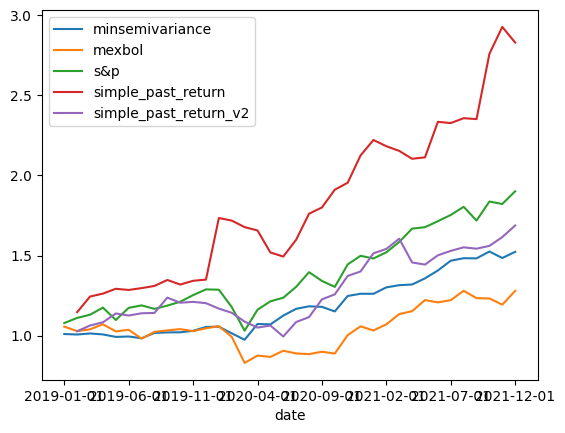

In [37]:
all_Df.plot()

## Past returns and RSI

In [71]:
def spr_rsi(asset):
    
    if asset.rsi( 10 ).pct_change(periods = 1).iloc[-1] <= 0:
        return None

    return asset.df["close"].pct_change( periods = 1 ).iloc[-1]

spr_rsi_strategy = {
    "SimplePastReturns_RSI":{
        "function":spr_rsi,
        "time":30,
        "type":"filter",
        "filter":"highest",
        "filter_qty": 0.3
    }
}

spr_rsi_df = build_strategy( spr_rsi_strategy, run = True )
print( f"Anual return: { 100*(spr_rsi_df['acc'].iloc[ -1 ] ** ( 1/3 ) - 1) } %" )


Folder already exists C:\Users\ramon\Documents\Trading\WorkingDir\gbm\results\MX\1m_1/SimplePastReturns_RSI/30_
Folder already exists C:\Users\ramon\Documents\Trading\WorkingDir\gbm\results\MX\1m_1/SimplePastReturns_RSI/30_/efficientsemivariance/minsemivariance/1_1m_36
Issues to download ALEATIC from 2019-03-31 00:00:00 to 2019-05-01 00:00:00
Issues to download C from 2019-07-31 00:00:00 to 2019-09-01 00:00:00
Issues to download FINAMEXO from 2020-02-29 00:00:00 to 2020-04-01 00:00:00
Issues to download URBI from 2021-07-31 00:00:00 to 2021-09-01 00:00:00
Issues to download TS from 2021-11-30 00:00:00 to 2022-01-01 00:00:00
route       C:\Users\ramon\Documents\Trading\WorkingDir\gb...
sharpe                                               0.440496
sortino                                              2.305521
std                                                  0.075619
neg std                                              0.014448
min net                                             -0.062

RSI 7

sharpe                                               0.440497
sortino                                              2.654835
std                                                  0.075451
neg std                                              0.012519
min net                                             -0.053606
acc                                                  2.978982
mean net                                             0.033236

RSI 10

sharpe                                               0.440496
sortino                                              2.305521
std                                                  0.075619
neg std                                              0.014448
min net                                             -0.062193
acc                                                   2.98527
mean net                                              0.03331

In [63]:
all_Df["spr_rsi"] = spr_rsi_df["acc"]

<AxesSubplot:xlabel='date'>

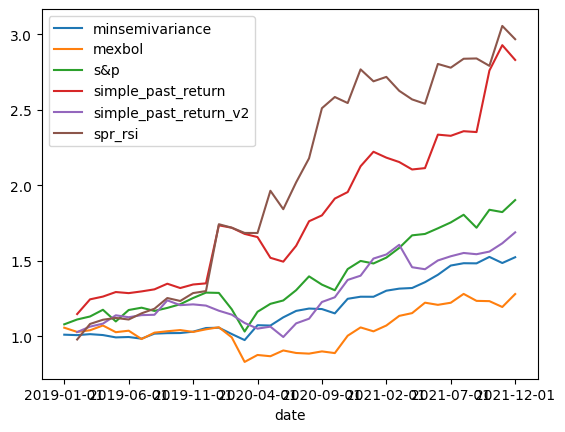

In [72]:
all_Df.plot()

## Past Return, RSI Slope and RSI Threshold


In [249]:
def spr_rsi_thr(asset):

    # s = (asset.rsi( 10 ).pct_change(periods = 1).iloc[-1] > 0) and ( asset.rsi( 10 ) < 75 )

    return asset.df["close"].pct_change( periods = 1 ) # * s

spr_rsi_df , sim = build_strategy_v2( spr_rsi_thr, filter= "highest", filter_qty = 0.3)


239
Could compute exp returns with exception Exp returns is a pandas DataFrame with more than one column
                   AAL         AAPL         AAXJ    ABBV          ABT  \
date                                                                    
2000-02-01         NaN          NaN          NaN     NaN          NaN   
2000-03-01         NaN          NaN          NaN     NaN          NaN   
2000-04-01         NaN          NaN          NaN     NaN          NaN   
2000-05-01         NaN          NaN          NaN     NaN          NaN   
2000-06-01         NaN          NaN          NaN     NaN          NaN   
...                ...          ...          ...     ...          ...   
2018-09-01  764.909973  1052.989990  1333.750000  1857.5  1295.000000   
2018-10-01  695.000000  1114.262451  1282.000000  1720.0  1415.000000   
2018-11-01  816.000000   912.054993  1358.849976  1732.0  1487.000000   
2018-12-01  628.789978   770.375000  1259.250000  1816.0  1416.500000   
2019-01-01  696.000

AttributeError: 'PyPort' object has no attribute '_exp_returns'

In [220]:
sim.analysis_df.iloc[-1]



AAL    -0.035041
AAPL    0.030949
AAXJ   -0.039279
ABBV    0.100787
ABT     0.053739
          ...   
XLK    -0.014044
XLP     0.042763
XLV     0.035000
XOM    -0.044391
ZM     -0.155557
Name: 2021-12-01 00:00:00, Length: 239, dtype: float64

In [217]:
all_Df["spr_rsi_thr"] = spr_rsi_df["acc"]

<AxesSubplot:xlabel='date'>

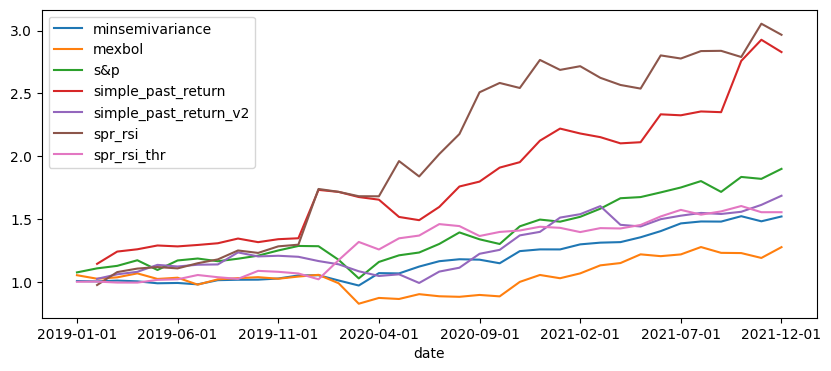

In [218]:
all_Df.plot(figsize = (10,4))

## Lower Momentum

In [4]:
lm = pd.read_csv( pwd.format("lowermomentum") )
lm = lm.sort_values(by = "acc", ascending=False).reset_index(drop = True)

In [6]:
for i in range(3):
    print( lm["route"].iloc[i] )

C:\Users\ramon\Documents\Trading\WorkingDir\gbm\results\MX\1m_1/LowestMomentum_3_0.4/20_/efficientsemivariance/minsemivariance/1_1m_20
C:\Users\ramon\Documents\Trading\WorkingDir\gbm\results\MX\1m_1/LowestMomentum_4_0.3/20_/efficientsemivariance/minsemivariance/1_1m_20
C:\Users\ramon\Documents\Trading\WorkingDir\gbm\results\MX\1m_1/LowestMomentum_3_0.2/20_/efficientsemivariance/minsemivariance/1_1m_10


<AxesSubplot:>

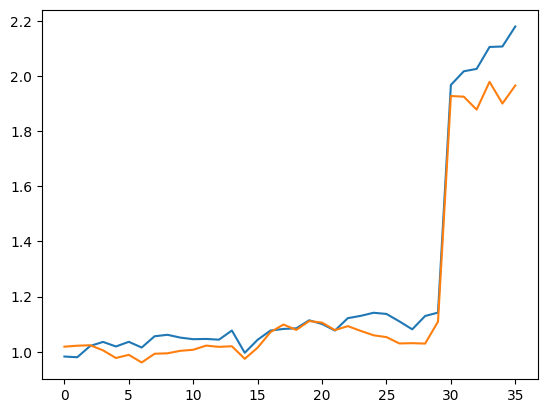

In [9]:
pd.read_csv( lm["route"].iloc[0] + "/resume.csv" )["acc"].plot()
pd.read_csv( lm["route"].iloc[1] + "/resume.csv" )["acc"].plot()

### With freq

In [19]:
lmf = pd.read_csv( pwd.format("lowermomentum_withFreq") )
lmf = lmf.sort_values(by = "acc", ascending=False).reset_index(drop = True)
lmf = separate(lmf)

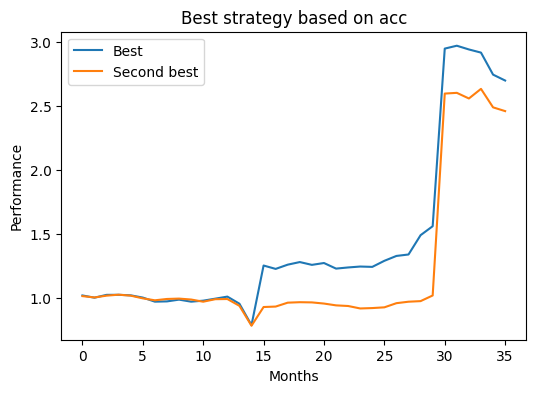

In [41]:
plots(lmf)

In [44]:
lmf[["s", "f", "period", "pct"]] = lmf["strategy"].str.split("_", expand = True)

In [45]:
xp.box( lmf, x = "f", y = "acc" ).show()
xp.box( lmf, x = "period", y = "acc" ).show()
xp.box( lmf, x = "pct", y = "acc" ).show()

## Lower momentum and RSI Smoth slope

In [41]:
mr = pd.read_csv( pwd.format("lowermomentum_rsismothslope") )
mr = mr.sort_values(by = "acc", ascending=False).reset_index(drop = True)
mr = separate(mr)

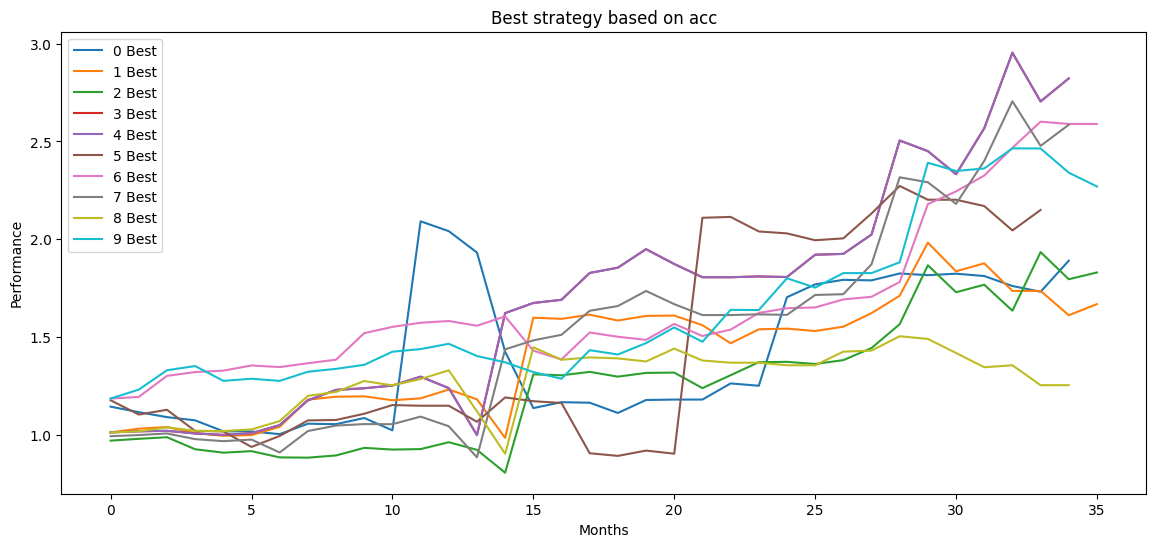

In [35]:
best = 10

plt.figure(figsize = (14,6))
    
for i in range( best ):
    pd.read_csv( mr["route"].iloc[i] + "/resume.csv" )["acc"].plot(label = f"{i} Best")
    # pd.read_csv( df["route"].iloc[1] + "/resume.csv" )["acc"].plot(label = "Second best")

plt.title("Best strategy based on acc")
plt.legend(loc = 2)
plt.xlabel("Months")
plt.ylabel("Performance")
plt.show()

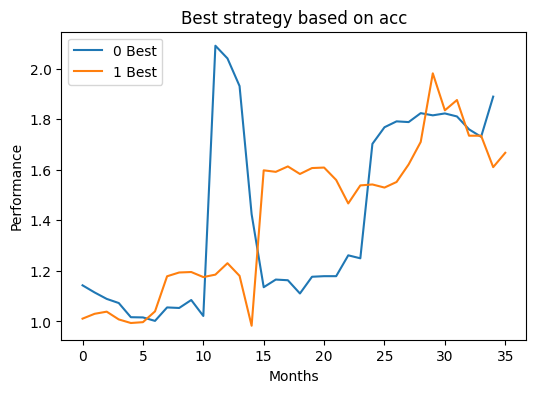

In [46]:
plots(mr)

## Momentum + RSI Smoth Slope + EMA Slope

In [6]:
mrs = pd.read_csv( pwd.format("lowermomentum_rsismothslope_emaslope") )
mrs = mrs.sort_values(by = "acc", ascending=False).reset_index(drop = True)
mrs = separate(mrs)

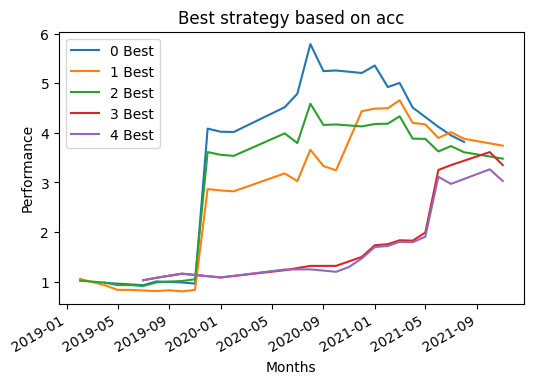

In [56]:
plots(mrs, best = 5)

In [9]:
for i in range(10):
    print(mrs.iloc[i]["strategy"])

LowestMomentum_4_0.3_RSISmonthSlope_7_7_3_0.3_EMASlope_10_4_0.5
LowestMomentum_4_0.4_RSISmonthSlope_7_7_3_0.3_EMASlope_10_3_0.5
LowestMomentum_4_0.4_RSISmonthSlope_7_7_3_0.3_EMASlope_10_4_0.5
LowestMomentum_4_0.3_RSISmonthSlope_14_7_3_0.3_EMASlope_10_4_0.5
LowestMomentum_4_0.3_RSISmonthSlope_14_7_3_0.3_EMASlope_20_4_0.5
LowestMomentum_4_0.3_RSISmonthSlope_11_7_3_0.3_EMASlope_40_4_0.5
LowestMomentum_4_0.3_RSISmonthSlope_14_7_3_0.3_EMASlope_40_4_0.5
LowestMomentum_4_0.3_RSISmonthSlope_11_7_3_0.3_EMASlope_20_4_0.5
LowestMomentum_4_0.4_RSISmonthSlope_7_7_3_0.3_EMASlope_10_4_0.5
LowestMomentum_4_0.3_RSISmonthSlope_11_7_3_0.3_EMASlope_80_4_0.5
